### **Imports and Global Config**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import xml.etree.ElementTree as ET
import urllib.request
import tarfile

# Fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# --- Constants ---
S = 7      # Grid size
B = 2      # Number of boxes per cell
C = 20     # VOC classes count
img_size = 448
λ_coord = 5
λ_noobj = 0.5

VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat",
    "chair","cow","diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]

# Download VOC 2007 
if not os.path.exists('VOCdevkit'):
    url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
    urllib.request.urlretrieve(url, 'VOCtrainval_06-Nov-2007.tar')
    with tarfile.open('VOCtrainval_06-Nov-2007.tar') as tar:
        tar.extractall()

### **Dataset Class**

In [5]:
class VOCDataset(Dataset):
    def __init__(self, root, split='trainval', transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        with open(f'{root}/VOC2007/ImageSets/Main/{split}.txt') as f:
            self.ids = f.read().strip().split()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = f'{self.root}/VOC2007/JPEGImages/{img_id}.jpg'
        xml_path = f'{self.root}/VOC2007/Annotations/{img_id}.xml'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Parse annotation XML
        boxes, labels = [], []
        root_xml = ET.parse(xml_path).getroot()
        for obj in root_xml.findall('object'):
            cls = obj.find('name').text.lower().strip()
            if cls not in VOC_CLASSES:
                continue
            cls_idx = VOC_CLASSES.index(cls)
            bbox = obj.find('bndbox')
            x1 = float(bbox.find('xmin').text)
            y1 = float(bbox.find('ymin').text)
            x2 = float(bbox.find('xmax').text)
            y2 = float(bbox.find('ymax').text)
            boxes.append([x1, y1, x2, y2])
            labels.append(cls_idx)

        boxes = np.array(boxes)
        labels = np.array(labels)

        # Resize and transform
        h0, w0 = img.shape[:2]
        img = cv2.resize(img, (img_size, img_size))
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img / 255., dtype=torch.float32).permute(2, 0, 1)

        target = self.encode_target(boxes, labels, w0, h0)
        return img, target

    def encode_target(self, boxes, labels, w_orig, h_orig):
        target = np.zeros((S, S, B * 5 + C))
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            cx = ((x1 + x2) / 2) / w_orig
            cy = ((y1 + y2) / 2) / h_orig
            bw = (x2 - x1) / w_orig
            bh = (y2 - y1) / h_orig

            i = int(cy * S)
            j = int(cx * S)
            i = min(max(i, 0), S - 1)
            j = min(max(j, 0), S - 1)

            cx_cell = cx * S - j
            cy_cell = cy * S - i
            bw = max(bw, 1e-6)
            bh = max(bh, 1e-6)

            target[i, j, 0:5] = [cx_cell, cy_cell, np.sqrt(bw), np.sqrt(bh), 1]
            target[i, j, 5:10] = [0, 0, 0, 0, 0]
            target[i, j, 10 + label] = 1
        return torch.tensor(target, dtype=torch.float32)


### **YOLO V1 Model**

In [6]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super().__init__()
        self.S, self.B, self.C = S, B, C

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 128, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            *[nn.Sequential(nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1),
                            nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1))
              for _ in range(4)],
            nn.Conv2d(512, 512, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, S * S * (B * 5 + C))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1, self.S, self.S, self.B * 5 + self.C)


### **Loss Functin**

In [7]:
def yolo_loss(pred, target):
    obj_mask = target[..., 4] > 0
    noobj_mask = target[..., 4] == 0

    pred_box = pred[..., 0:4]
    target_box = target[..., 0:4]

    pred_box_wh = torch.sqrt(torch.clamp(pred_box[..., 2:4], min=1e-6))
    target_box_wh = torch.sqrt(torch.clamp(target_box[..., 2:4], min=1e-6))

    loss_xy = F.mse_loss(pred_box[obj_mask][..., 0:2], target_box[obj_mask][..., 0:2], reduction='sum')
    loss_wh = F.mse_loss(pred_box_wh[obj_mask], target_box_wh[obj_mask], reduction='sum')
    loss_coord = λ_coord * (loss_xy + loss_wh)

    loss_obj = F.mse_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4], reduction='sum')
    loss_noobj = λ_noobj * F.mse_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4], reduction='sum')
    loss_cls = F.mse_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:], reduction='sum')

    total_loss = loss_coord + loss_obj + loss_noobj + loss_cls
    return total_loss / pred.size(0)


### **Training Loop**

In [8]:
import matplotlib.pyplot as plt  # Ensure this is imported at the top

def train():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')

    dataset = VOCDataset('VOCdevkit', 'trainval', transform=None)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

    model = YOLOv1(S, B, C).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 15
    loss_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, targets in dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss = yolo_loss(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), loss_history, marker='o', color='blue')
    plt.title('YOLOv1 Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model, dataset


### **Visualization Function**

In [9]:
def plot_results(model, dataset, num=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()

    for i in range(num):
        img, target = dataset[i]
        img_in = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img_in)[0].cpu().numpy()

        img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8).copy()

        # Draw GT boxes (green)
        for i_ in range(S):
            for j_ in range(S):
                for b in range(B):
                    if target[i_, j_, b*5+4] > 0:
                        cx, cy, w, h = target[i_, j_, b*5:b*5+4]
                        cx += j_
                        cy += i_
                        cx /= S
                        cy /= S
                        w = w**2
                        h = h**2
                        x1 = int((cx - w/2) * img_size)
                        y1 = int((cy - h/2) * img_size)
                        x2 = int((cx + w/2) * img_size)
                        y2 = int((cy + h/2) * img_size)
                        cv2.rectangle(img_np, (x1,y1), (x2,y2), (0,255,0), 2)

        # Draw Predicted boxes (red)
        for i_ in range(S):
            for j_ in range(S):
                for b in range(B):
                    conf = pred[i_, j_, b*5+4]
                    if conf > 0.5:
                        cx, cy, w, h = pred[i_, j_, b*5:b*5+4]
                        cx += j_
                        cy += i_
                        cx /= S
                        cy /= S
                        w = max(w, 0)**2
                        h = max(h, 0)**2
                        x1 = int((cx - w/2) * img_size)
                        y1 = int((cy - h/2) * img_size)
                        x2 = int((cx + w/2) * img_size)
                        y2 = int((cy + h/2) * img_size)
                        cv2.rectangle(img_np, (x1,y1), (x2,y2), (255,0,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(img_np)
        plt.axis('off')
        plt.show()


### **Run Training and Plotting**

Using device: cuda
Epoch 1/15 - Loss: 8.1917
Epoch 2/15 - Loss: 7.4275
Epoch 3/15 - Loss: 7.3492
Epoch 4/15 - Loss: 7.3229
Epoch 5/15 - Loss: 7.3009
Epoch 6/15 - Loss: 7.2954
Epoch 7/15 - Loss: 7.2904
Epoch 8/15 - Loss: 62.0569
Epoch 9/15 - Loss: 10.0827
Epoch 10/15 - Loss: 7.2782
Epoch 11/15 - Loss: 7.2670
Epoch 12/15 - Loss: 7.2604
Epoch 13/15 - Loss: 7.2427
Epoch 14/15 - Loss: 7.2853
Epoch 15/15 - Loss: 7.2462


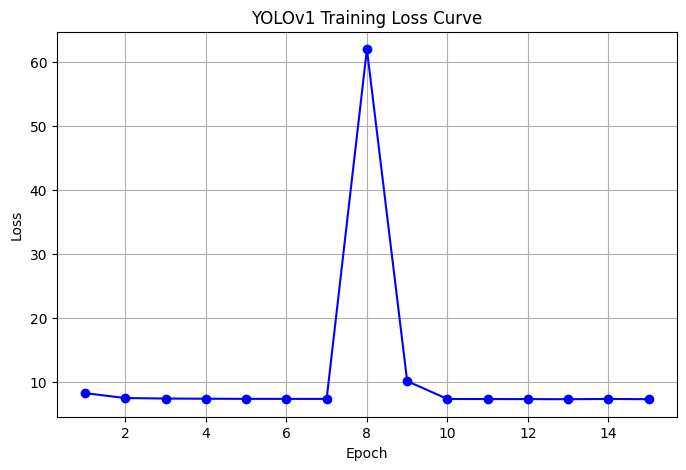

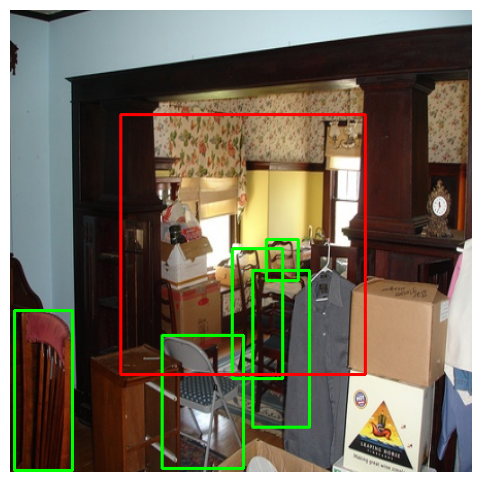

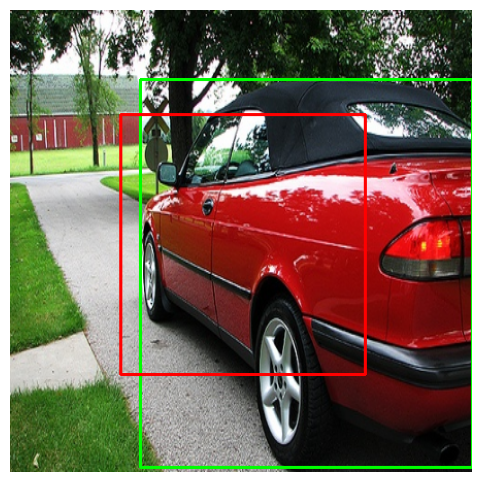

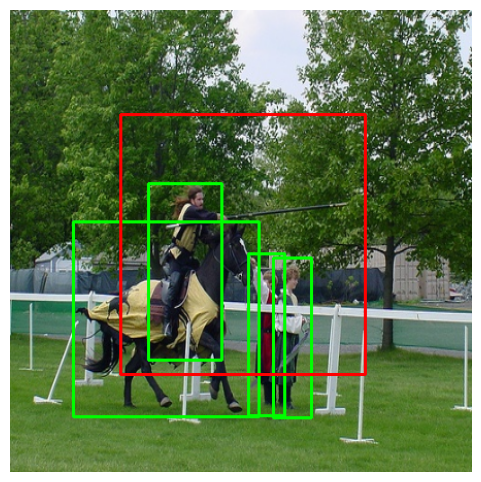

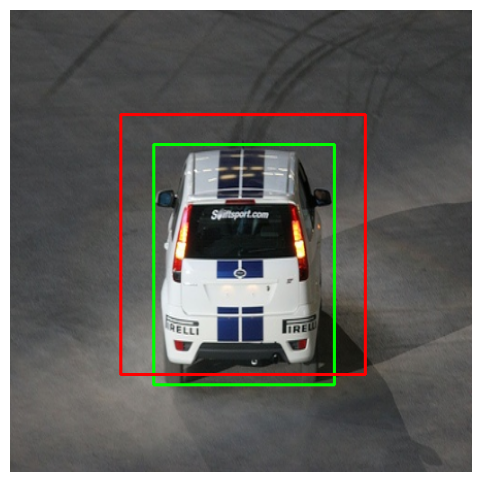

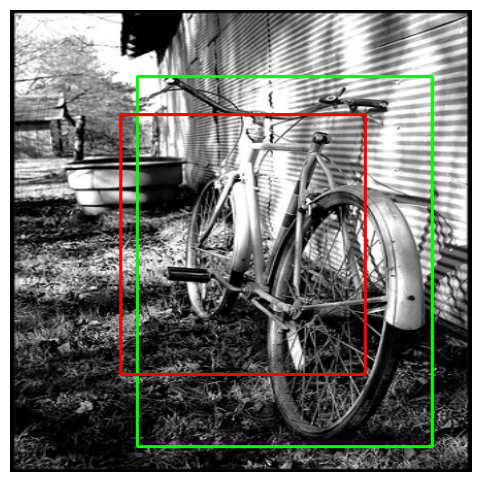

In [10]:
if __name__ == '__main__':
    model, dataset = train()
    plot_results(model, dataset)


### **Ground Truth boxes**

Using device: cuda
Epoch 1/15 - Loss: 8.0748
Epoch 2/15 - Loss: 7.5171
Epoch 3/15 - Loss: 7.3682
Epoch 4/15 - Loss: 7.3354
Epoch 5/15 - Loss: 7.3012
Epoch 6/15 - Loss: 7.3045
Epoch 7/15 - Loss: 71.4813
Epoch 8/15 - Loss: 7.3280
Epoch 9/15 - Loss: 7.2817
Epoch 10/15 - Loss: 7.2955
Epoch 11/15 - Loss: 7.2596
Epoch 12/15 - Loss: 7.2643
Epoch 13/15 - Loss: 7.3212
Epoch 14/15 - Loss: 7.8179
Epoch 15/15 - Loss: 7.2722


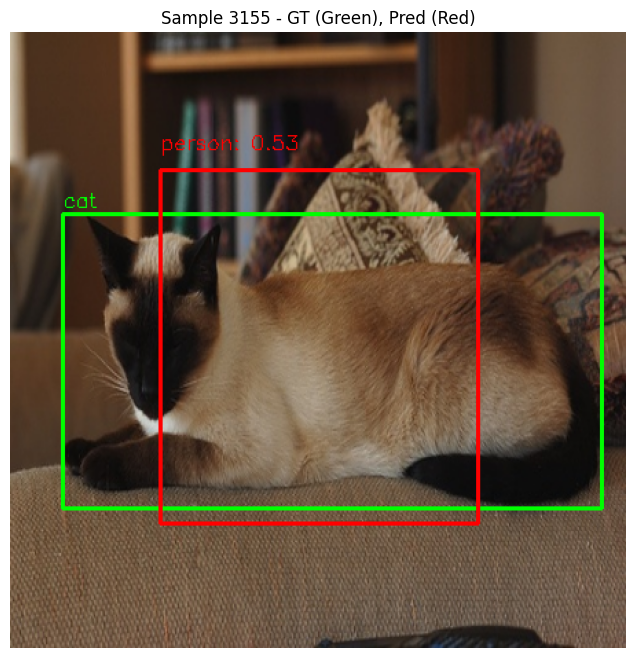

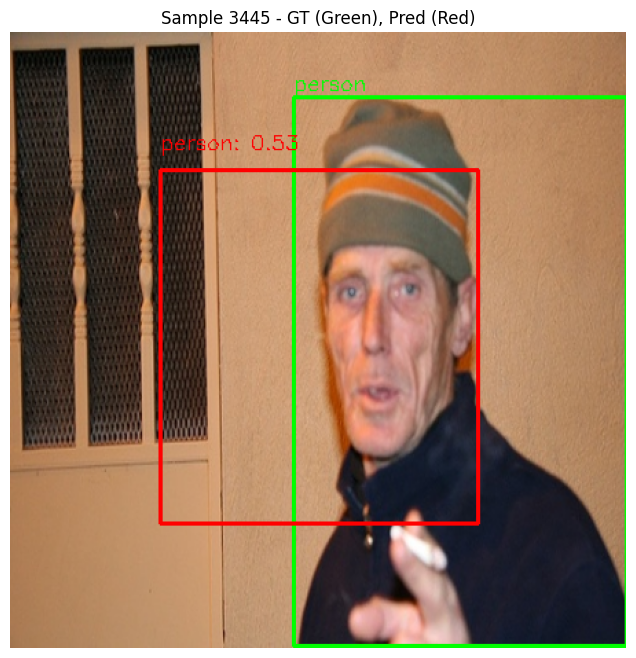

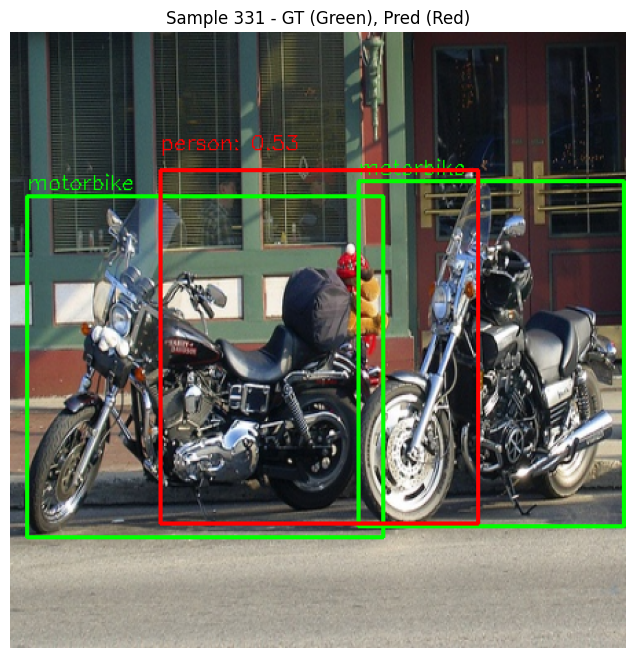

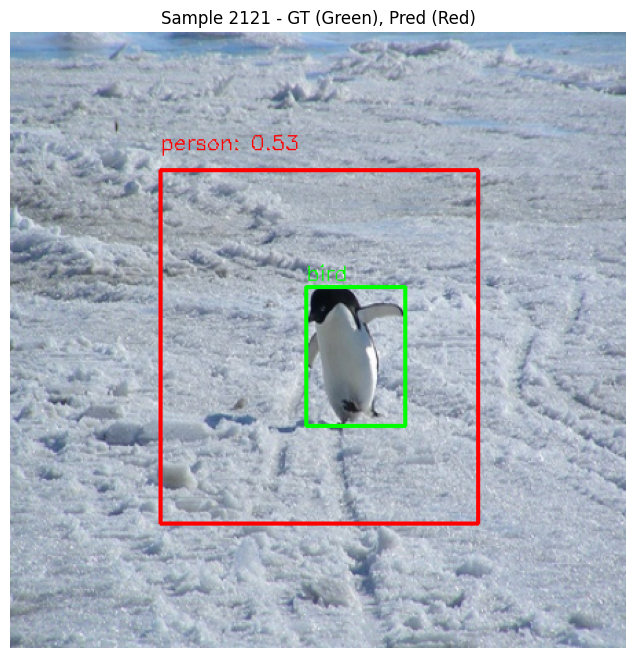

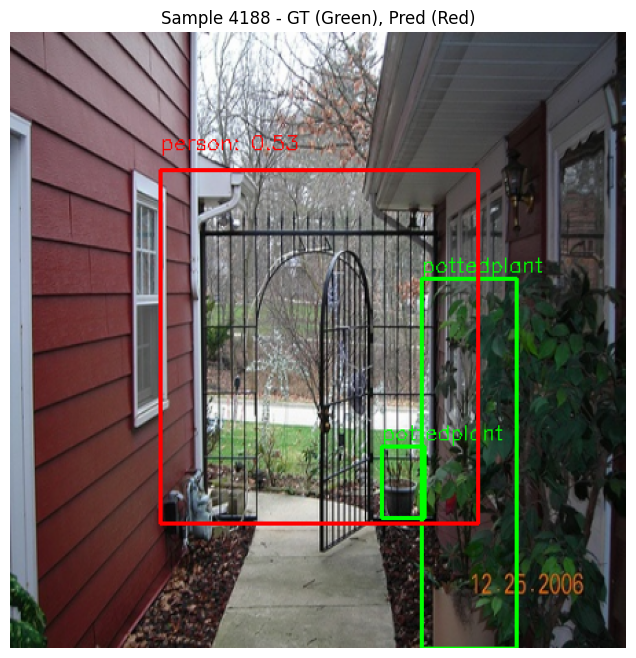

In [13]:
# Visualize results with predicted and ground truth boxes.

import matplotlib.pyplot as plt
import numpy as np
def plot_results(model, dataset, num=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()

    indices_to_plot = random.sample(range(len(dataset)), num)

    for idx in indices_to_plot:
        img, target = dataset[idx]
        img_in = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img_in)[0].cpu().numpy()

        img_np = img.permute(1, 2, 0).numpy() * 255
        img_np = img_np.astype(np.uint8).copy()

        # Draw GT boxes (green)
        for i_ in range(S):
            for j_ in range(S):
                # Check if an object exists in this cell in the ground truth
                if target[i_, j_, 4] > 0: # Assuming the first box contains the ground truth if any
                    # Find the class index from the one-hot encoding
                    gt_class_idx = torch.argmax(target[i_, j_, 10:]).item()
                    gt_class_name = VOC_CLASSES[gt_class_idx]

                    # Get ground truth box coordinates (relative to cell)
                    cx_cell, cy_cell, w_sqrt, h_sqrt = target[i_, j_, 0:4]

                    # Convert to absolute coordinates relative to image size
                    cx_abs = (j_ + cx_cell) / S * img_size
                    cy_abs = (i_ + cy_cell) / S * img_size
                    w_abs = w_sqrt**2 * img_size
                    h_abs = h_sqrt**2 * img_size

                    x1 = int(cx_abs - w_abs / 2)
                    y1 = int(cy_abs - h_abs / 2)
                    x2 = int(cx_abs + w_abs / 2)
                    y2 = int(cy_abs + h_abs / 2)

                    cv2.rectangle(img_np, (x1,y1), (x2,y2), (0,255,0), 2)
                    cv2.putText(img_np, gt_class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Draw Predicted boxes (red) with confidence > 0.5
        for i_ in range(S):
            for j_ in range(S):
                for b in range(B):
                    conf = pred[i_, j_, b*5+4]
                    if conf > 0.5:
                        cx_cell, cy_cell, w_sqrt, h_sqrt = pred[i_, j_, b*5:b*5+4]

                        # Convert to absolute coordinates relative to image size
                        cx_abs = (j_ + cx_cell) / S * img_size
                        cy_abs = (i_ + cy_cell) / S * img_size
                        w_abs = max(w_sqrt, 0)**2 * img_size # Ensure positive w,h
                        h_abs = max(h_sqrt, 0)**2 * img_size

                        x1 = int(cx_abs - w_abs / 2)
                        y1 = int(cy_abs - h_abs / 2)
                        x2 = int(cx_abs + w_abs / 2)
                        y2 = int(cy_abs + h_abs / 2)

                        # Get predicted class
                        pred_class_idx = np.argmax(pred[i_, j_, 10:])
                        pred_class_name = VOC_CLASSES[pred_class_idx]

                        cv2.rectangle(img_np, (x1,y1), (x2,y2), (255,0,0), 2)
                        cv2.putText(img_np, f'{pred_class_name}: {conf:.2f}', (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)


        plt.figure(figsize=(8,8))
        plt.imshow(img_np)
        plt.title(f'Sample {idx} - GT (Green), Pred (Red)')
        plt.axis('off')
        plt.show()

if __name__ == '__main__':
    model, dataset = train()
    plot_results(model, dataset, num=5)


# **README**

# YOLOv1 Object Detection on VOC Dataset

This project implements the **YOLOv1** object detection model from scratch in PyTorch, trained on the **Pascal VOC 2007** dataset.

## Project Overview

- **Dataset:** Pascal VOC 2007 (trainval split)  
- **Model:** YOLOv1 architecture (S=7 grid cells, B=2 bounding boxes, C=20 classes)  
- **Framework:** PyTorch  
- **Loss:** Custom YOLO loss function combining localization, confidence, and classification losses  
- **Training:** Adam optimizer, gradient clipping, 15 epochs  
- **Visualization:** Loss curve plot and bounding box visualization for predictions and ground truth  

---
VOCdevkit/
├── VOC2007/
│ ├── Annotations/
│ ├── ImageSets/
│ │ └── Main/
│ ├── JPEGImages/
│ └── ...

---
## 🧠 Model Overview

- **Grid Size (S):** 7 × 7
- **Bounding Boxes (B):** 2 per cell
- **Classes (C):** 20 Pascal VOC classes
- **Input Image Size:** 448 × 448
- **Loss:** Combines localization, confidence, and classification losses

**Install dependencies:**

   ```bash
   pip install torch torchvision matplotlib opencv-python
---
| Component        | Description                                                                            |
| ---------------- | -------------------------------------------------------------------------------------- |
| `VOCDataset`     | Loads images and XML annotations, resizes images, and encodes targets into YOLO format |
| `YOLOv1`         | CNN based on YOLOv1 architecture from the paper                                        |
| `yolo_loss`      | Custom loss including localization, confidence, and classification components          |
| `train()`        | Training loop for model                                                                |
| `plot_results()` | Visualizes predictions alongside ground truth                                          |



   📖 References
Original paper: You Only Look Once: Unified, Real-Time Object Detection (Redmon et al., 2016)

Pascal VOC Dataset
